# Getting started with Gammapy

## Introduction

This is a getting started tutorial for [Gammapy](http://docs.gammapy.org/).

It shows an application example for the following classes:

- [gammapy.catalog.SourceCatalog](http://docs.gammapy.org/en/latest/api/gammapy.catalog.SourceCatalog.html), specifically [gammapy.catalog.SourceCatalog3FGL](http://docs.gammapy.org/en/latest/api/gammapy.catalog.SourceCatalog3FGL.html)
- [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html)
- [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
- TBD: spatial model
- [gammapy.spectrum.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html), specifically the [PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html) and [ExponentialCutoffPowerLaw3FGL](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw3FGL.html) models.
- [gammapy.time.LightCurve](http://docs.gammapy.org/en/latest/api/gammapy.time.LightCurve.html)

We will also work with the following Astropy classes:

- `astropy.table.Table` - See the [astropy.table docs](http://astropy.readthedocs.io/en/latest/table/index.html).
- `astropy.coordinates.SkyCoord` - See the [astropy.coordinates docs](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
- `astropy.time.Time` - See the [astropy.time docs](http://astropy.readthedocs.io/en/latest/time/index.html)

If you're not familiar with those, you should also check out the [Astropy introduction for Gammapy users](astropy_introduction.ipynb).

We will use the [Second Fermi-LAT Catalog of High-Energy Sources (2FHL) catalog](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2FHL/)
and corresponding event list and have a look at an image, spectrum and light curve for the brightest sources.

## Setup

First, as usual with IPython notebooks and Python, we need to do some setup and imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings; warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

## Dataset

- Load 2FHL catalog, select brightest sources.
- Load event list, cone select events and print some stats

In [4]:
from gammapy.catalog import source_catalogs
cat = source_catalogs['2fhl']
table = cat.table
table.sort('TS')
table = table[::-1]
table[:9][['Source_Name', 'ASSOC', 'CLASS']].pprint()

   Source_Name       ASSOC     CLASS
----------------- ------------ -----
2FHL J1104.4+3812      Mkn 421   bll
2FHL J0534.5+2201         Crab   pwn
2FHL J1653.9+3945      Mkn 501   bll
2FHL J1555.7+1111  PG 1553+113   bll
2FHL J2158.8-3013 PKS 2155-304   bll
2FHL J0507.9+6737 1ES 0502+675   bll
2FHL J1427.0+2348 PKS 1424+240   bll
2FHL J0222.6+4301       3C 66A   bll
2FHL J1015.0+4926  1H 1013+498   bll


## Images

The plan:

* Read two sky images from FITS files
* Smooth an image
* Plot the images
* Reproject one image onto the other

In [5]:
from gammapy.image import SkyImage

In [6]:
vela_2fhl = SkyImage.read("$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_vela.fits.gz", ext=2)
vela_wmap = SkyImage.read("$GAMMAPY_EXTRA/datasets/images/Vela_region_WMAP_K.fits")

In [7]:
vela_smooth = vela_2fhl.smooth('gauss', radius=1)

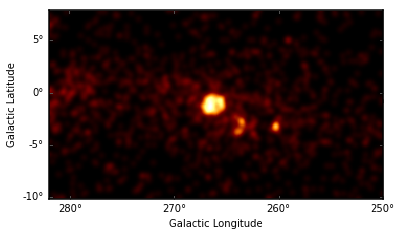

In [8]:
vela_smooth.plot();

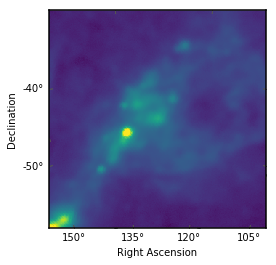

In [9]:
norm = vela_wmap.plot_norm(stretch='sqrt',max_percent=99.9)
vela_wmap.plot(cmap='viridis',norm=norm);

## Image reprojection

* The projection of the WMAP image is tangential in radec system.
* We want to align the two images.
* We therefore reproject the WMAP one.
* We also keep only a cutout around the Vela position.

In [10]:
# Reproject WMAP image on Fermi image WCS
reproj_wmap = vela_wmap.reproject(vela_smooth)

In [11]:
# Cut out sub-images for a given center and size
center = SkyCoord(265.0, -2.0, unit='deg', frame='galactic')
size = 9.0 * u.deg

vela_cutout = vela_smooth.cutout(center, size)
wmap_cutout = reproj_wmap.cutout(center, size)

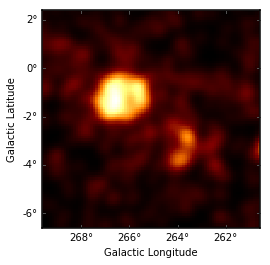

In [12]:
vela_cutout.plot();

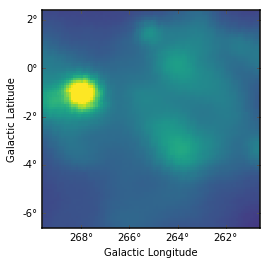

In [13]:
wmap_cutout.plot(cmap='viridis', norm=norm);

## Spectrum

- Plot the spectra
- Also plot event energy distributions

In [14]:
source = cat['2FHL J0534.5+2201'] # Crab nebula
# source = cat['Crab']

In [15]:
source.flux_points.table[['e_min', 'e_max', 'dnde']]

e_min,e_max,dnde
GeV,GeV,GeV(9/8) / (cm2 s TeV(17/8))
float64,float64,float64
50.0,171.0,2.01666069866e-05
171.0,585.0,1.44599896753e-06
585.0,2000.0,9.15157602841e-08


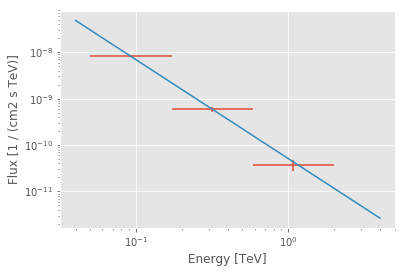

In [16]:
energy_range = [50 * u.GeV, 1 * u.TeV]
source.flux_points.plot()
# source.spectrum.butterfly().plot()
source.spectral_model.plot(energy_range=[40, 4000] * u.GeV, energy_power=0)

## Light curve

- Plot light curve
- Plot event time histogram

In [18]:
from gammapy.time import plot_fermi_3fgl_light_curve
# This is an example from 3FGL
# TODO: refactor this code and make it work for 2FHL also
# plot_fermi_3fgl_light_curve('3FGL J0349.9-2102')

## Exercises

* Sky images: add a marker and circle at the Vela pulsar position
* Sky images: overplot WMAP contours on Fermi-LAT image
* Sky images: find maximum brightness location in WMAP image. Try to identify the source.
* Source catalog: load PKS 2155-304 and plot it's spectrum
* Event list: make a counts energy spectrum for some region or source
* Spectrum: overplot 3FGL & 2FHL spectrum for some source
* Lightcurve: Find time of maximum flux
* Lightcurve: restrict to sub time range
* Lightcurve: compute variability via `f_var` for a steady and a variable source

## What next?

This was a quick introduction to some of the high-level classes in Astropy and Gammapy.

* To learn more about those classes, go to the API docs (links are in the introduction at the top).
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](http://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list.